In [ ]:
# ML_in_Finance_ARIMA-HFT
# Author: Matthew Dixon
# Version: 1.0 (24.7.2019)
# License: MIT
# Email: matthew.dixon@iit.edu
# Notes: tested on Mac OS X with Python 3.6 and Tensorflow 1.3.0
# Citation: Please cite the following reference if this notebook is used for research purposes:
# Dixon M.F., I. Halperin and P. Bilokon, Machine Learning in Finance: From Theory to Practice, Springer Graduate textbook Series, 2020. 

# Overview
The purpose of this notebook is to demonstrate the application of ARIMA time series modeling to high frequency data. The model predicts changes in the VWAP (volume weighted average prices) based on historical observations of the VWMAP and an exogenous variable, the current Order Flow Imbalance (OFI). See https://arxiv.org/abs/1011.6402 for more details on OFI.

The notebook describes many of the steps in Chapter 6 on applying the Dickey-Fuller test to establish stationarity of the endogenous series, followed by use of the ACF and PACF to identify the ARIMA model order. Typically, addition diagnostic tests are performed on the model residual but omitted here. Instead we simply compare the forecast with the actual VWAP change.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from ofi import *
from statsmodels.regression.linear_model import OLS

%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 9)

Load the data

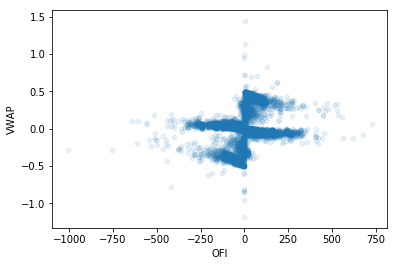

In [61]:
sp500quotes = pd.read_pickle('../data/09012013_quotes.pickle')
time_as_index(sp500quotes)

sp500ofi = ofi(sp500quotes['Bid Size'], sp500quotes['Ask Size'],
               sp500quotes['Bid Price'], sp500quotes['Ask Price'])
sp500smart = smart_price(sp500quotes['Bid Price'], sp500quotes['Bid Size'], sp500quotes['Ask Price'], sp500quotes['Ask Size'])

sp500smart_diff = sp500smart.diff(1)
pd.concat([sp500ofi, sp500smart_diff], axis=1).plot(kind='scatter', x='OFI', y='VWAP', alpha=0.1)

### Stationarity
It is essential to determine whether the time series is "stationary". Informally, stationarity is when the auto-covariance is independent of time. Failure to establish stationarity will almost certainly lead to misinterpretation of model identification and diagnostics tests. Moreover, stationarity is decisive in characterizing the prediction problem and whether to use a more advanced architecture. In particular, we can expect a plain RNN to perform poorly if the data is non-stationary as the RNN exhibits fixed auto-covariance. 

We perform an Augmented Dickey-Fuller test to establish stationarity under the assumption that the time series has a constant bias but does not exhibit a time trend. In other words, we assume that the time series is already de-trended. 

If the stationarity test fails, even after first de-trending the time series, then one potential recourse is to simply take differences of time series and predict $\Delta y_t$.

The null hypothesis of the Augmented Dickey-Fuller is that there is a unit root, with the alternative that there is no unit root. If the p-value is above $(1-\alpha)$, then we cannot reject that there is a unit root. Note that a subset of the time series is used to reduce the computation time of the test. Test separately on both the dependent and the independent variable.

In [60]:
sample = sp500smart_diff[1:]
adf, p, usedlag, nobs, cvs, aic = sm.tsa.stattools.adfuller(sample)

In [62]:
adf_results_string = 'ADF: {}\np-value: {},\nN: {}, \ncritical values: {}'
print(adf_results_string.format(adf, p, nobs, cvs))

ADF: -51.65350270603819
p-value: 0.0,
N: 82102, 
critical values: {'1%': -3.4304296509764045, '5%': -2.861575204399113, '10%': -2.566788738084499}


We reject the Null hypothesis at the 99% level - the difference in smart prices contain no unit roots and are stationary.

## Determine the order p of the AR model from the PACF plot

#### Autoregressive Model Identification: The partial auto-correlation
It is important to determine the number of lags, the sequence length, required in the RNN by statistical analysis. A brute-force approach will in general be too time-consuming.

A partial auto-correlation at lag $h\geq 2$ is a conditional auto-correlation between a variable, $X_t$, and its $h^{th}$ lag, $X_{t-h}$ under the assumption that we control for the values of the intermediate lags, $X_{t-1},\dots, X_{t-h+1}$:

$$\begin{align}\tau_h&:=\tau(X_t, X_{t-h}; X_{t-1},\dots, X_{t-h+1})\\
&:=\frac{\gamma(X_t, X_{t-h}; X_{t-1},\dots, X_{t-h+1})}{\sqrt{\gamma(X_t |X_{t-1},\dots, X_{t-h+1})\gamma(X_{t-h} |X_{t-1},\dots, X_{t-h+1}))}}
,\end{align}$$
where $\gamma_h:=\gamma(X_tX_{t-h})$ is the lag-$h$ autocovariance. The partial autocorrelation function $\tau_h:\mathbb{N} \rightarrow [-1,1]$ is a map $h:\mapsto \tau_h$.

The estimated partial auto-correlation function (PACF) can be used to identify the order of an autoregressive time series model. Values of $|\tau_h|$ greater or equal to $\frac{\Phi^{-1}(\alpha)}{\sqrt{T}}$, where $T$ is the number of observations and $\Phi(z)$ is the standard normal CDF, are significant lag $h$ partial autocorelations at the $\alpha$ confidence level.

We use the stattools package to estimat the PACF. The `nlags` parameter is the maximum number of lags used for PACF estimation of the endogeneous variable - SP500 mid-prices. 

In [69]:
pacf = sm.tsa.stattools.pacf(sp500smart_diff[1:], nlags=30)

Since $\Phi^{-1}(0.99) \simeq 2.58$:

In [70]:
T = len(sp500smart_diff)

sig_test = lambda tau_h: np.abs(tau_h) > 2.58/np.sqrt(T)

We find the first lag which isn't significant at the 99% level and automatically determine the number of lags needed in our autoregressive model as one below this value.

In [71]:
for i in range(len(pacf)):
    if sig_test(pacf[i]) == False:
        p = i - 1
        print('p set to', p)
        break

p set to 17


This may lead to a high order model, with more lags than strictly necessary. We could view this value, informally, as an upper bound on the number of lags needed. We can also simply identify the order of the model based on the plot of the PACF. In this case, a minimum of approximately 10 lags appears satisfactory, although more may be needed.  We plot the PACF function.

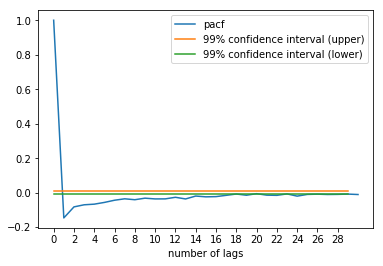

In [72]:
plt.plot(pacf, label='pacf')
plt.plot([2.58/np.sqrt(T)]*30, label='99% confidence interval (upper)')
plt.plot([-2.58/np.sqrt(T)]*30, label='99% confidence interval (lower)')
plt.xlabel('number of lags')
plt.xticks(np.arange(0,30,2))
plt.legend();

## Determine the order q of the MA model from the ACF plot
Evaluate the ACF on the endogenous variable - SP500 mid-prices

In [73]:
acf = sm.tsa.stattools.acf(sp500smart_diff[1:], nlags=30)

In [74]:
T = len(sp500smart)

sig_test = lambda tau_h: np.abs(tau_h) > 2.58/np.sqrt(T)
q=0

In [75]:
for i in range(len(acf)):
    if sig_test(acf[i]) == False:
        q = i - 1
        print('q set to', q)
        break

q set to 8


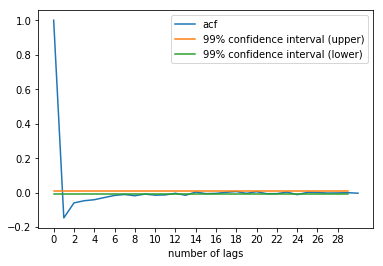

In [76]:
plt.plot(acf, label='acf')
plt.plot([2.58/np.sqrt(T)]*30, label='99% confidence interval (upper)')
plt.plot([-2.58/np.sqrt(T)]*30, label='99% confidence interval (lower)')
plt.xlabel('number of lags')
plt.xticks(np.arange(0,30,2))
plt.legend();

train on the first 10,000 samples

In [84]:
n_train=10000
p=10
model = sm.tsa.ARIMA(endog=sp500smart_diff[1:(n_train+1)], order=(p,0,q), exog=sp500ofi[0:n_train])

/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [85]:
model_fit = model.fit(disp=0)

/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [86]:
model_fit.summary()

/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/arima_model.py:1455: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(-inv(hess)))
/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                   VWAP   No. Observations:                10000
Model:                    ARMA(10, 8)   Log Likelihood                9235.107
Method:                       css-mle   S.D. of innovations              0.096
Date:                Wed, 13 May 2020   AIC                         -18428.214
Time:                        19:47:45   BIC                         -18276.797
Sample:                             0   HQIC                        -18376.960
                                                                              
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.0002      0.000      0.725      0.469      -0.000       0.001
OFI             0.0006   2.29e-05     24.054      0.000       0.001       0.001
ar.L1.VWAP     -0.0603      0.337     -0.179      0.858      -0.720       0.599
ar.L2.VWAP      0.4320      0.258      1.677      0.094      -0.073       0.937
ar.L3.VWAP      0.5077      0.447      1.137      0.256      -0.368       1.383
ar.L4.VWAP     -0.2772      0.991     -0.280      0.780      -2.219       1.665
ar.L5.VWAP     -0.4133      0.146     -2.830      0.005      -0.700      -0.127
ar.L6.VWAP     -0.1662      0.655     -0.254      0.800      -1.450       1.117
ar.L7.VWAP      0.3997      0.379      1.054      0.292      -0.344       1.143
ar.L8.VWAP     -0.0193      0.189     -0.102      0.919      -0.391       0.352
ar.L9.VWAP     -0.0011      0.016     -0.070      0.944      -0.032       0.030
ar.L10.VWAP    -0.0473      0.012     -4.091      0.000      -0.070      -0.025
ma.L1.VWAP     -0.1361      0.337     -0.405      0.686      -0.796       0.523
ma.L2.VWAP     -0.5825      0.173     -3.371      0.001      -0.921      -0.244
ma.L3.VWAP     -0.5109      0.548     -0.932      0.351      -1.585       0.563
ma.L4.VWAP      0.3522      0.948      0.371      0.710      -1.506       2.211
ma.L5.VWAP      0.3931        nan        nan        nan         nan         nan
ma.L6.VWAP      0.0895      0.832      0.108      0.914      -1.541       1.720
ma.L7.VWAP     -0.4751      0.389     -1.221      0.222      -1.238       0.287
ma.L8.VWAP      0.0393      0.257      0.153      0.879      -0.465       0.544
                                    Roots                                     
==============================================================================
                   Real          Imaginary           Modulus         Frequency
------------------------------------------------------------------------------
AR.1            -0.9828           -0.4914j            1.0989           -0.4262
AR.2            -0.9828           +0.4914j            1.0989            0.4262
AR.3            -0.4175           -1.0272j            1.1088           -0.3114
AR.4            -0.4175           +1.0272j            1.1088            0.3114
AR.5             0.9827           -0.7090j            1.2117           -0.0995
AR.6             0.9827           +0.7090j            1.2117            0.0995
AR.7             1.4113           -0.3300j            1.4493           -0.0366
AR.8             1.4113           +0.3300j            1.4493            0.0366
AR.9            -1.0054           -1.8993j            2.1490           -0.3275
AR.10           -1.0054           +1.8993j            2.1490            0.3275
MA.1            -0.9730           -0.5086j            1.0979           -0.4233
MA.2            -0.9730           +0.5086j            1.0979            0.4233
MA.3            -0.4099           -1.0168j            1.0963           -0.3110
MA.4            -0.4099           +1.0168j            1.09

# Forecast

In [87]:
start_index = n_train
horizon = 500
end_index = start_index + horizon
forecast = model_fit.predict(start=start_index, end=end_index, exog=sp500ofi)

/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


In [88]:
forecast.index=sp500smart_diff[n_train:(n_train+horizon+1)].index

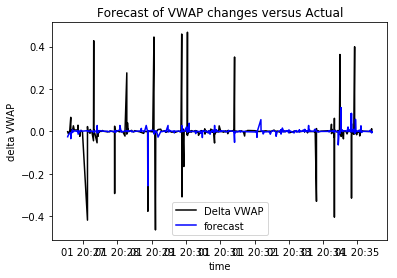

In [89]:
plt.plot(sp500smart_diff[n_train:(n_train+horizon+1)], color='black', label='Delta VWAP')
plt.plot(forecast, color='blue', label='forecast')
plt.title('Forecast of VWAP changes versus Actual')
plt.xlabel('time')
plt.ylabel('delta VWAP')
plt.legend()